In [1]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/marcos/.pyenv/versions/3.11.1/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.1 (main, Jul 13 2023, 05:11:48) [GCC 11.3.0].


In [2]:
import torch

In [3]:
import pandas as pd
import numpy as np

In [4]:
#!pip install dtw-python
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error
)


In [6]:
import numpy as np
import torch
from typing import Union

def standard_normalize(
    data: Union[torch.Tensor, np.ndarray, list],
    dim: int = 1,
    eps: float = 1e-8,
    return_type: str = "auto"
):
    """
    Normaliza os dados para média 0 e desvio padrão 1 (z-score)
    ao longo da dimensão especificada.

    Args:
        data (torch.Tensor | np.ndarray | list): Dados de entrada.
        dim (int): Dimensão ao longo da qual normalizar (default=1).
        eps (float): Pequeno valor para evitar divisão por zero.
        return_type (str): Tipo de retorno. Pode ser:
            - "auto": retorna no mesmo tipo da entrada
            - "torch": sempre retorna torch.Tensor
            - "numpy": sempre retorna numpy.ndarray

    Returns:
        torch.Tensor | np.ndarray: Dados normalizados (z-score).
    """
    # Detecta o tipo de entrada
    input_type = "torch" if isinstance(data, torch.Tensor) else \
                 "numpy" if isinstance(data, np.ndarray) else \
                 "list"

    # Converte para tensor
    tensor = torch.as_tensor(data, dtype=torch.float32)

    # Normalização z-score
    mean = tensor.mean(dim=dim, keepdim=True)
    std = tensor.std(dim=dim, keepdim=True, unbiased=False)
    normed = (tensor - mean) / (std + eps)

    # Decide formato de saída
    if return_type == "torch" or (return_type == "auto" and input_type == "torch"):
        return normed
    elif return_type == "numpy" or (return_type == "auto" and input_type in {"numpy", "list"}):
        return normed.numpy()
    else:
        raise ValueError(f"return_type '{return_type}' não suportado.")


In [7]:
!python3.11 -m pip install --upgrade pip
!pip install pyarrow

In [8]:
df = pd.read_parquet('/home/marcos/workdir/phd/Waikato_TAIAO/dataset_temperature_c_interpolation.parquet')
df.head()

,time,Napier_Aerodrome,Wellington_Aerodrome,Enderby_Island,Mokohinau_Island,Cape_Campbell,Westport_Aerodrome,Mahia_NZMHX,Nelson_Aerodrome,Queenstown_Aerodrome,...,Port_Taharoa,Palmerston_N,Gisborne_Aerodrome,Nugget_Point,Dunedin_Aerodrome,Cape_Reinga,Secretary_Island,Kaitaia_Aerodrome,Takapau_Plains,split
0,01-Apr-1993 00:00,15.0,17.0,7.0,17.0,11.0,17.0,14.0,15.0,8.0,...,15.0,14.0,16.0,10.0,8.0,17.0,14.0,16.5,11.4,True
1,01-Apr-1993 01:00,14.0,17.0,7.0,17.0,11.0,16.0,14.0,15.0,8.0,...,14.0,15.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
2,01-Apr-1993 02:00,14.0,17.0,7.0,17.0,11.0,16.0,15.0,15.0,7.0,...,14.0,14.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
3,01-Apr-1993 03:00,13.0,17.0,7.0,17.0,11.0,16.0,15.0,14.0,6.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True
4,01-Apr-1993 04:00,13.0,17.0,7.0,17.0,11.0,15.0,15.0,14.0,7.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True


In [9]:
station = "Napier_Aerodrome"
train_data = df.query("split == True")[station].values[-1000:]
test_data  = df.query(" split == False ")[station].values[:500]

train_data.shape, test_data.shape

((1000,), (500,))

In [10]:
# X = df.ts.values[:2000]
# len(X)

In [11]:
# X = standard_normalize(X, dim=0)
# X.shape

In [12]:
# train_size = int(0.8 * len(X))
# train_data = X[:train_size]
# test_data = X[train_size:]

In [13]:
#
# For Torch - 200
#

# tfm = timesfm.TimesFm(
#       hparams=timesfm.TimesFmHparams(
#           backend="gpu",
#           per_core_batch_size=20,
#           horizon_len=100,
#       ),
#       checkpoint=timesfm.TimesFmCheckpoint(
#           huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
#   )

#
# 500
# 

tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=20,
          horizon_len=100,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23121.85it/s]


In [14]:
x_test = np.concatenate([train_data, test_data[:100]])
x_test.shape

(1100,)

In [15]:
x_test_torch = torch.from_numpy(x_test)

In [16]:
x_test.shape

(1100,)

In [17]:
frequency_input = [0]

point_forecast, experimental_quantile_forecast = tfm.forecast(
    [x_test],
    freq=frequency_input,
)

In [18]:
point_forecast.shape

(1, 100)

In [19]:
y_true = test_data[100:200]
y_pred = point_forecast.reshape(100)

In [20]:
#  Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

#  Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

#  Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R2 Score
r2 = r2_score(y_true, y_pred)

# Median Absolute Error (MedAE)
medae = median_absolute_error(y_true, y_pred)

# Explained Variance Score
evs = explained_variance_score(y_true, y_pred)

mape = mean_absolute_percentage_error(y_true, y_pred) 

alignment = dtw(y_true, y_pred, keep_internals=True)


# Exibindo os resultados
print(f"DTW ....: {alignment.normalizedDistance:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")

DTW ....: 0.8985
Mean Absolute Error (MAE): 2.2963
Mean Squared Error (MSE): 8.9711
Root Mean Squared Error (RMSE): 2.9952
MAPE: 0.1291
R² Score: 0.4725
Median Absolute Error (MedAE): 1.9039
Explained Variance Score: 0.4876


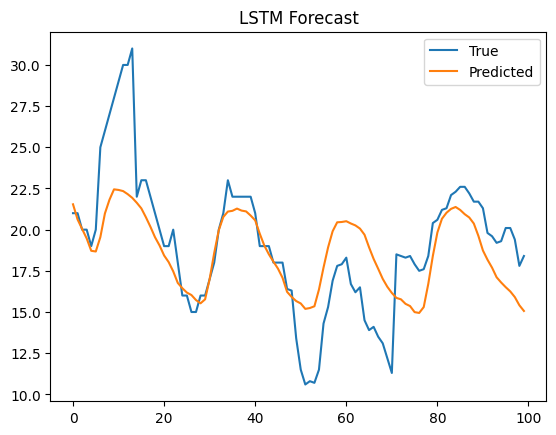

In [21]:
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Forecast")
plt.show()

<Axes: xlabel='Index', ylabel='Query value'>

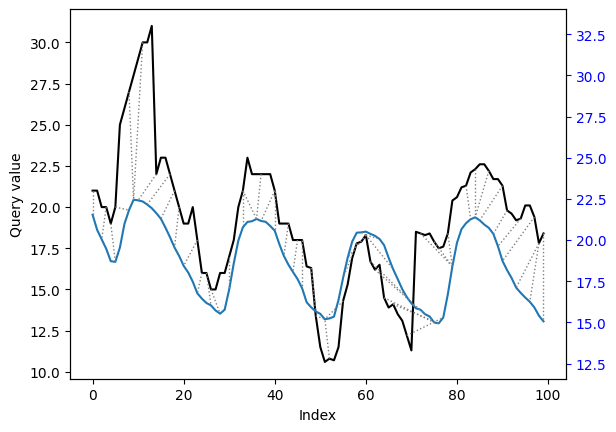

In [22]:
alignment.plot(type="twoway",offset=-2)

In [23]:
# part II

ini = 0
end = 100
features = train_data.copy()

trues = []
preds = []

for i in range(4):

    features = np.concatenate([features, test_data[ini:end]])

    frequency_input = [0]
    
    point_forecast, experimental_quantile_forecast = tfm.forecast(
        [x_test],
        freq=frequency_input,
    )

    y_pred = point_forecast.reshape(100)
        
    
    trues.extend(test_data[ini+100:end+100].tolist())
    preds.extend(y_pred.tolist())
    
    ini += 100
    end += 100

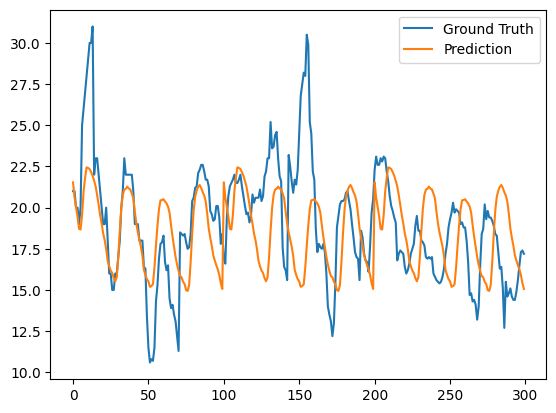

In [24]:
## create dataframe to save results
plt.plot(trues, label="Ground Truth")
plt.plot(preds, label="Prediction")
plt.legend()
plt.show()

In [25]:
df = pd.DataFrame({"y_true": trues, "y_hat": preds})
# df.to_csv("log_timesfm_200.csv", index=False)
df.to_csv("log_timesfm_500.csv", index=False)
df.head()

,y_true,y_hat
0,21.0,21.538925
1,21.0,20.619604
2,20.0,20.041733
3,20.0,19.466911
4,19.0,18.716125


In [26]:
y_true = df.y_true
y_pred = df.y_hat

In [27]:
#  Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

#  Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

#  Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R2 Score
r2 = r2_score(y_true, y_pred)

# Median Absolute Error (MedAE)
medae = median_absolute_error(y_true, y_pred)

# Explained Variance Score
evs = explained_variance_score(y_true, y_pred)

mape = mean_absolute_percentage_error(y_true, y_pred) 

alignment = dtw(y_true, y_pred, keep_internals=True)


# Exibindo os resultados
print(f"DTW ....: {alignment.normalizedDistance:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")

DTW ....: 0.7060
Mean Absolute Error (MAE): 2.8323
Mean Squared Error (MSE): 13.0238
Root Mean Squared Error (RMSE): 3.6089
MAPE: 0.1515
R² Score: -0.0300
Median Absolute Error (MedAE): 2.5337
Explained Variance Score: -0.0143
